In [5]:
%run key_imports.py
%run sabr.py

In [6]:
SEED = 42
rng = default_rng(SEED)

N_TIMES = 32
N_SAMPLES = 2048

Z1 = rng.standard_normal((N_SAMPLES, N_TIMES))
Z2 = rng.standard_normal((N_SAMPLES, N_TIMES))

T = 1
dt = T / (N_TIMES)
ts = np.linspace(dt, T, N_TIMES).reshape((1, -1))

vol_of_vol = rng.uniform(0, 1, N_SAMPLES).reshape((-1, 1))
beta = rng.uniform(0, 1, N_SAMPLES)
rho = rng.uniform(0, 1, N_SAMPLES)
V0 = rng.uniform(0.1, 0.3, N_SAMPLES).reshape((-1, 1))

# exact simulation of the volatility process
Vt =  np.hstack([V0, V0 * np.exp(-(0.5 * vol_of_vol ** 2) * ts + vol_of_vol * np.sqrt(dt) * np.cumsum(Z2, axis = 1))])

Ft = np.zeros((N_SAMPLES, N_TIMES + 1))
Ft[:,0] = np.linspace(0.5, 1.5, N_SAMPLES)






deltas = np.zeros((N_SAMPLES, N_TIMES + 1))

for i in range(N_TIMES):
    Ft[:, i + 1] = cev_step(Ft[:,i], Vt[:,i], beta, dt, Z1[:,i], rho, Z2[:,i])
    vec_fun = lambda F0, V0, beta, dt, Z1, rho, Z2: grad(cev_step, argnums = 0)(F0, V0, beta, dt, Z1, rho, Z2)
    deltas[:, i] = jnp.vectorize(vec_fun)(Ft[:,i], Vt[:,i], beta, dt, Z1[:,i], rho, Z2[:,i])
    
    
call_payoff = lambda x: jnp.maximum(jnp.exp(x) - 1.0, 0)  
y = np.array(call_payoff(Ft[:,-1]))
deltas[:, -1] = jnp.vectorize(grad(call_payoff))(Ft[:, -1])
final_grad = jnp.vectorize(grad(call_payoff))(Ft[:,-1])
# deltas = np.cumprod(deltas[:, ::-1], axis = 1) * np.array(final_grad).reshape((-1, 1)) 


"""
Combine to create dataset
"""

feat_names = ['S/K', "V", 'ttm',"vol_of_vol","beta", "rho"]

f_to_i = lambda x: feat_names.index(x)

ts = np.linspace(0, T, N_TIMES + 1)
Xs = np.vstack([Ft.reshape(-1),
               Vt.reshape(-1),
               T - np.repeat(ts, N_SAMPLES).reshape((N_TIMES + 1, - 1)).T.reshape(-1),
               np.repeat(vol_of_vol, N_TIMES + 1).reshape(-1),
               np.repeat(beta, N_TIMES + 1),
               np.repeat(rho, N_TIMES + 1)]).T

y = np.maximum(Ft[:,-1] - 1.0, 0.0)
ys = np.repeat(y, N_TIMES + 1)
y = ys.reshape(-1)


print(Xs.shape, ys.shape)
assert Xs.shape[0] == ys.shape[0]

"""
Writeout to csv
"""
X_df = pd.DataFrame(Xs, columns = feat_names)

X_df['call_payoff'] = ys
X_df['pathwise_delta'] = deltas[:, ].reshape(-1)

X_df['digital_payoff'] = (ys > 0) * 1

# X_df['call_true'] = jax_BS_call(Xs[:,0], Xs[:,1])
# X_df['digital_true'] = jax_BS_digital(Xs[:,0], Xs[:,1])
# X_df['true_d_log(S/K)'], X_df['true_d_ttm'] = first_order_greeks(moneyness = Xs[:,0], ttm = Xs[:,1])
# X_df['true_d2_log(S/K)'] = second_order_greek(moneyness = Xs[:,0], ttm = Xs[:,1])
X_df['path'] = X_df.index // N_TIMES
X_df.to_csv("sabr.csv", index=False)
display(X_df)

(67584, 6) (67584,)


,S/K,V,ttm,vol_of_vol,beta,rho,call_payoff,pathwise_delta,digital_payoff,path
0,0.500000,0.158370,1.00000,0.908552,0.527624,0.851425,0.000000,1.007302,0,0
1,0.484786,0.117671,0.96875,0.908552,0.527624,0.851425,0.000000,0.999336,0,0
2,0.486330,0.130503,0.93750,0.908552,0.527624,0.851425,0.000000,0.991164,0,0
3,0.505204,0.123213,0.90625,0.908552,0.527624,0.851425,0.000000,0.988554,0,0
4,0.529581,0.120819,0.87500,0.908552,0.527624,0.851425,0.000000,1.015166,0,0
...,...,...,...,...,...,...,...,...,...,...
67579,2.064677,0.153141,0.12500,0.004011,0.728664,0.091674,1.121834,0.994516,1,2111
67580,2.085010,0.153282,0.09375,0.004011,0.728664,0.091674,1.121834,0.995444,1,2111
67581,2.101918,0.153079,0.06250,0.004011,0.728664,0.091674,1.121834,0.997993,1,2111
67582,2.109430,0.153067,0.03125,0.004011,0.728664,0.091674,1.121834,0.996666,1,2111


Text(0.5, 1.0, 'Sample payoffs vs Moneyness')

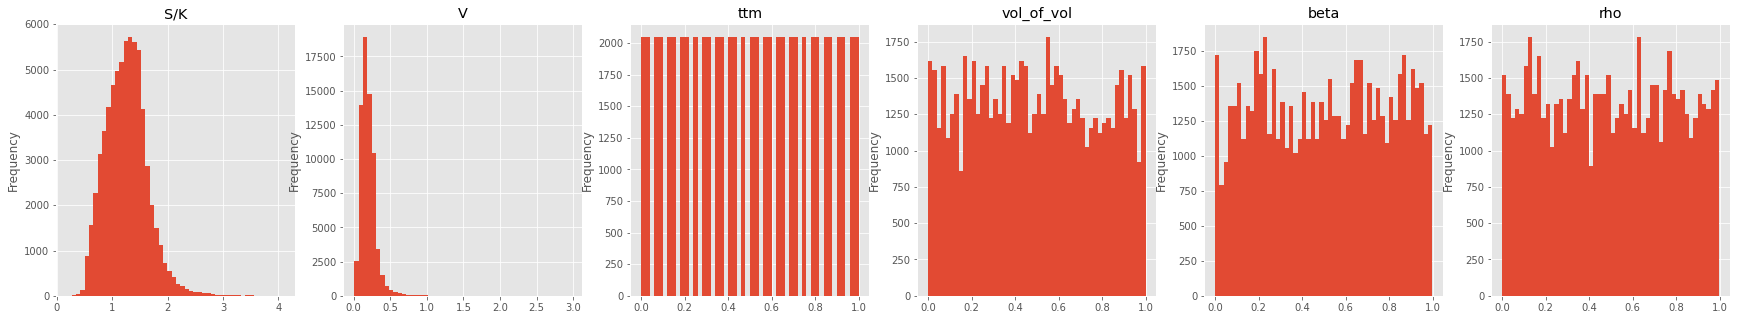

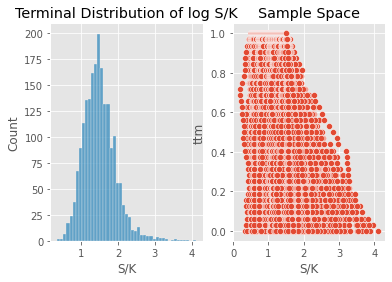

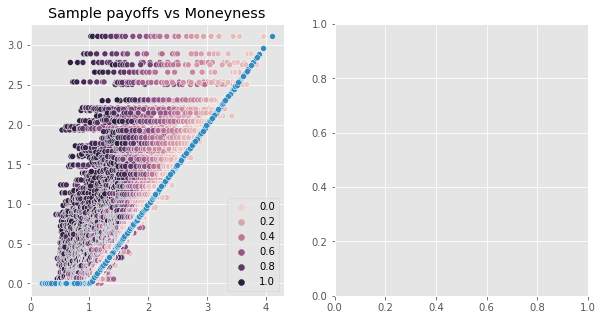

In [25]:
"""
Visualise data
"""
# Marginal Distributions of Parameter Space
fig, ax = plt.subplots(figsize=(5 * len(feat_names), 5), ncols = len(feat_names))
for i in range(len(feat_names)):
    X_df.iloc[:, i].plot(kind = 'hist', ax = ax[i], bins = 50)
    ax[i].set_title(feat_names[i])
# Terminal Distribution of underlying
fig, ax = plt.subplots(ncols = 2)
sns.scatterplot(x = Xs[:, f_to_i("S/K")], y = Xs[:, f_to_i("ttm")], ax = ax[1])
sns.histplot(Ft[:, -1], ax = ax[0])
ax[0].set_title("Terminal Distribution of log S/K")
ax[0].set_xlabel("S/K")
ax[1].set_title("Sample Space")
ax[1].set_xlabel("S/K")
ax[1].set_ylabel("ttm")
# sample payoff, intrinsic val v S/K

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
intrinsic_val = np.maximum(Xs[:,f_to_i("S/K")] - 1.0, 0)
sns.scatterplot(x = Xs[:,f_to_i("S/K")], y = ys, hue = Xs[:, f_to_i("ttm")], ax = ax[0])
sns.scatterplot(x = Xs[:,f_to_i("S/K")], y = intrinsic_val, ax = ax[0])
ax[0].set_title("Sample payoffs vs Moneyness")
# sns.scatterplot(x = X_df['S/K'], y = X_df['call_true'], hue = X_df['ttm'], ax = ax[1])
# ax[1].set_title("True payoffs vs Monyness")

In [9]:
X_df

,S/K,V,ttm,vol_of_vol,beta,rho,call_payoff,pathwise_delta,digital_payoff,path
0,0.500000,0.158370,1.00000,0.908552,0.527624,0.851425,0.000000,1.007302,0,0
1,0.484786,0.117671,0.96875,0.908552,0.527624,0.851425,0.000000,0.999336,0,0
2,0.486330,0.130503,0.93750,0.908552,0.527624,0.851425,0.000000,0.991164,0,0
3,0.505204,0.123213,0.90625,0.908552,0.527624,0.851425,0.000000,0.988554,0,0
4,0.529581,0.120819,0.87500,0.908552,0.527624,0.851425,0.000000,1.015166,0,0
...,...,...,...,...,...,...,...,...,...,...
67579,2.064677,0.153141,0.12500,0.004011,0.728664,0.091674,1.121834,0.994516,1,2111
67580,2.085010,0.153282,0.09375,0.004011,0.728664,0.091674,1.121834,0.995444,1,2111
67581,2.101918,0.153079,0.06250,0.004011,0.728664,0.091674,1.121834,0.997993,1,2111
67582,2.109430,0.153067,0.03125,0.004011,0.728664,0.091674,1.121834,0.996666,1,2111


<AxesSubplot:xlabel='S/K', ylabel='pathwise_delta'>

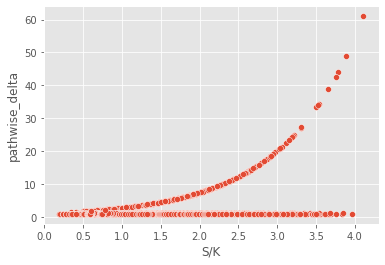

In [8]:
sns.scatterplot(X_df['S/K'], X_df['pathwise_delta'])

$$V_{T} = V_{t}\exp((-0.5\alpha^{2}(T - t)) + \alpha (W_{T} - W_{t}) )$$

$$dV_{t} = \nu V_{t} dW_{2, t}$$

$$dF_{t} = V_{t}F_{t}^{\beta}dW_{1, t}$$

$$d\log F_{t} = \frac{1}{F_{t}}dF_{t} + \frac{-1}{2F_{t}^{2}}(dF_{t})^{2} = V_{t}F_{t - 1}^{\beta - 1} dW_{ 1, t} - \frac{V_{t}^{2}F_{t}^{2\beta - 2}}{2} dt$$


$F, V, \nu, \beta, \rho, T$


$d(\lambda F_{t}) = V_{t} \lambda^{1 - \beta} (\lambda F_{t})^{\beta}$

hence

$$P(\lambda F_{t}, \lambda^{1 - \beta}\alpha, \beta, \rho, v)= \lambda P(F, \alpha, \beta, \rho, v)$$